In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

#os.chdir('/content/drive/MyDrive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [2]:
from skimage.transform import resize
import time
import numpy as np
from numpy import save
from numpy import load
import pandas as pd
import matplotlib as plt
import imutils
import dlib
import cv2
import imageio
from imutils import face_utils
from keras.utils import np_utils, generic_utils
from sklearn.utils import shuffle

In [3]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [4]:
#@title JFCL: Rutas drive X,Y para train,test y val
#@markdown - **Mayito:** puede crearse una nueva celda de estas con las rutas de su drive, así vamos dejando el notebook más generico.
X_train=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_train.npy')
X_val=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_val.npy')
X_test=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_test.npy')
y_train=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_train.npy')
y_val=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_val.npy')
y_test=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_test.npy')

### Normalizacion y completamiento de los datos

In [5]:
def normalize_it(X):
  v_min = X.min(axis=(2, 3), keepdims=True)
  v_max = X.max(axis=(2, 3), keepdims=True)
  X = (X - v_min)/(v_max - v_min)
  X = np.nan_to_num(X)
  return X

In [6]:
X_train = normalize_it(X_train)
X_val = normalize_it(X_val)
X_test = normalize_it(X_test)

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
y_val = np_utils.to_categorical(y_val, 10)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [7]:
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1200, 22, 100, 100, 1)
(200, 22, 100, 100, 1)
(100, 22, 100, 100, 1)


In [8]:
print(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3],X_train.shape[4])

1200 22 100 100 1


### Modelo

In [9]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model

In [24]:
model = Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

# # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 98, 98, 64)    1792      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 8, 47, 47, 128)    221312    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 23, 23, 128)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 22, 22, 256)    262400    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 11, 11, 256)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30976)            

In [25]:
t1 = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/120
38/38 [==============================] - 22s 570ms/step - loss: 2.3022 - accuracy: 0.1139 - val_loss: 2.2997 - val_accuracy: 0.1150
Epoch 2/120
38/38 [==============================] - 21s 565ms/step - loss: 2.3047 - accuracy: 0.1000 - val_loss: 2.2979 - val_accuracy: 0.1450
Epoch 3/120
38/38 [==============================] - 21s 552ms/step - loss: 2.2960 - accuracy: 0.1458 - val_loss: 2.2962 - val_accuracy: 0.1850
Epoch 4/120
38/38 [==============================] - 21s 551ms/step - loss: 2.3011 - accuracy: 0.0908 - val_loss: 2.2948 - val_accuracy: 0.2100
Epoch 5/120
38/38 [==============================] - 21s 556ms/step - loss: 2.2962 - accuracy: 0.1246 - val_loss: 2.2935 - val_accuracy: 0.1850
Epoch 6/120
38/38 [==============================] - 21s 558ms/step - loss: 2.2995 - accuracy: 0.0791 - val_loss: 2.2923 - val_accuracy: 0.1950
Epoch 7/120
38/38 [==============================] - 21s 555ms/step - loss: 2.2953 - accuracy: 0.1149 - val_loss: 2.2904 - val_accuracy:

In [26]:
#@title Save model
model.save('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/Notebooks/FinalExperimentation/Models/model1-1.h5')
#del model
#modelLoad = load_model('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/Notebooks/FinalExperimentation/Models/model1-1.h5')

### Entremaiento y validación

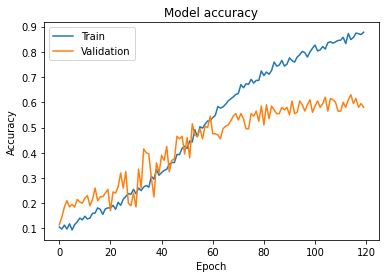

In [27]:
#@title Valores de Accuracy
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

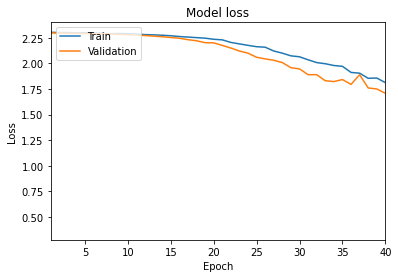

In [28]:
#@title Valores Loss
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Predicción de modelos

In [29]:
ypred = model.predict(X_test)

predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)] 

correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
#     print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy} on completely unseen data")

Accuracy = 0.26 on completely unseen data
